In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os
import datetime
import warnings
warnings.filterwarnings('ignore')
import imageio
from skimage import transform,io
import keras
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, TensorBoard
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
import math
from sklearn.model_selection import train_test_split
import pickle
from tensorflow.keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [2]:
def get_dummies(labels, class_name, index):
    dummy_arr = np.zeros((len(labels)))
    dummy_arr[index] += 1
    return dummy_arr

In [3]:
#@title Data tools V2 -> Preprocess test!
def mobilenet_v2_preprocessing(X_input):
    X_input = np.array(X_input)
    for i in range(0,X_input.shape[0]):
        x = X_train[i,:,:,:]
        x = np.expand_dims(x, axis=0)
        X_input[i,] = preprocess_input(x)
    return X_input

In [4]:
def load_and_split_data():
    N = 0
    labels = []

    for dirname, _, filenames in os.walk('./train/'):
        for filename in filenames:
            path = os.path.join(dirname, filename)
            splits = dirname.split('/')
            N += 1
            class_name = splits[-1]

            if class_name not in labels and class_name != '': labels.append(splits[-1])

    labels = np.array(labels)

    count = 0

    im_size = 224

    X1 = np.zeros((N, im_size, im_size, 3))
    y1 = np.zeros((N, len(labels)))

    for dirname, _, filenames in os.walk('./train/'):
        for filename in filenames:
            if filename == '.DS_Store': continue

            path = os.path.join(dirname, filename)        
            l = path.split('/')[-2]

            im = imageio.imread(path)/255. # normalize images
            X1[count, :, :] = transform.resize(im, (im_size, im_size, 3), mode='symmetric', preserve_range=True) # downsampling original image
            y1[count, :] = get_dummies(labels, l, np.where(labels == l)[0][0])

            count +=1
            
    # create data generator
    datagen = ImageDataGenerator( zoom_range=0.35, # zoom
            horizontal_flip=True, # horizontal flip
            brightness_range=[0.7,1.5]) # brightness

    # fit parameters from data
    datagen.fit(X1)

    X2 = np.zeros((N, im_size, im_size, 3))
    y2 = np.zeros((N, len(labels)))

    # Configure batch size and retrieve one batch of images
    for X_batch, y_batch in datagen.flow(X1, y1, batch_size=N):
        for i in range(0, N, 1):
            X2[i,:,:,:] = X_batch[i].reshape(im_size,im_size,3)/255.
            y2[i] = y_batch[i]
        # De esta manera paramos de generar imagenes aleatoriamente
        break
        
    X3 = np.zeros((N, im_size, im_size, 3))
    y3 = np.zeros((N, len(labels)))

    # Configure batch size and retrieve one batch of images
    for X_batch, y_batch in datagen.flow(X1, y1, batch_size=N):
        for i in range(0, N, 1):
            X3[i,:,:,:] = X_batch[i].reshape(im_size,im_size,3)/255.
            y3[i] = y_batch[i]
        # De esta manera paramos de generar imagenes aleatoriamente
        break
        
    X4 = np.zeros((N, im_size, im_size, 3))
    y4 = np.zeros((N, len(labels)))

    # Configure batch size and retrieve one batch of images
    for X_batch, y_batch in datagen.flow(X1, y1, batch_size=N):
        for i in range(0, N, 1):
            X4[i,:,:,:] = X_batch[i].reshape(im_size,im_size,3)/255.
            y4[i] = y_batch[i]
        # De esta manera paramos de generar imagenes aleatoriamente
        break
        
    X5 = np.zeros((N, im_size, im_size, 3))
    y5 = np.zeros((N, len(labels)))

    # Configure batch size and retrieve one batch of images
    for X_batch, y_batch in datagen.flow(X1, y1, batch_size=N):
        for i in range(0, N, 1):
            X5[i,:,:,:] = X_batch[i].reshape(im_size,im_size,3)/255.
            y5[i] = y_batch[i]
        # De esta manera paramos de generar imagenes aleatoriamente
        break
    
    X = np.concatenate((X1,X2,X3,X4,X5))
    y = np.concatenate((y1,y2,y3,y4,y5))

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)
    print("X_train shape: ", X_train.shape)
    print("y_train shape: ", y_train.shape)
    print("X_val shape: ", X_val.shape)
    print("y_val shape: ", y_val.shape)
    
    return X_train, X_val, y_train, y_val

In [5]:
X_train, X_val, y_train, y_val = load_and_split_data()


X_train shape:  (8715, 224, 224, 3)
y_train shape:  (8715, 11)
X_val shape:  (2905, 224, 224, 3)
y_val shape:  (2905, 11)


In [6]:
#@title Learning rate schedulers
class LearningRateDecay:
    def plot(self, epochs, title="Learning Rate Schedule"):
        # compute the set of learning rates for each corresponding
        # epoch
        lrs = [self(i) for i in epochs]
        # the learning rate schedule
        plt.style.use("ggplot")
        plt.figure()
        plt.plot(epochs, lrs)
        plt.title(title)
        plt.xlabel("Epoch #")
        plt.ylabel("Learning Rate")
        
class StepDecay(LearningRateDecay):
    def __init__(self, initAlpha=1e-5, factor=0.5, dropEvery=10):
        # store the base initial learning rate, drop factor, and
        # epochs to drop every
        self.initAlpha = initAlpha
        self.factor = factor
        self.dropEvery = dropEvery
        
    def __call__(self, epoch):
        # compute the learning rate for the current epoch
        exp = np.floor((1 + epoch) / self.dropEvery)
        alpha = self.initAlpha * (self.factor ** exp)
        
        # return the learning rate
        return float(alpha)

In [7]:
saved_autoencoder = load_model('autoencoderX.h5')

Metal device set to: Apple M1 Pro


2022-03-16 11:44:10.184115: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-16 11:44:10.184270: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
saved_autoencoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 32)        9

In [9]:
for l in saved_autoencoder.layers:
    print(l)
    l.trainable = False

In [10]:
activation = "relu"
classifier_model = keras.Sequential()

# inicio encoder
classifier_model.add(saved_autoencoder.layers[0])
classifier_model.add(saved_autoencoder.layers[1])
classifier_model.add(saved_autoencoder.layers[2])
classifier_model.add(saved_autoencoder.layers[3])
classifier_model.add(saved_autoencoder.layers[4])
classifier_model.add(saved_autoencoder.layers[5])
classifier_model.add(saved_autoencoder.layers[6])
classifier_model.add(saved_autoencoder.layers[7])

# final encoder 
classifier_model.add(Flatten())
classifier_model.add(Dropout(0.5)) 
classifier_model.add(Dense(units=128,activation=activation))
classifier_model.add(Dense(units=11, activation="softmax"))

In [11]:
initial_lr = 1e-3

In [12]:
#compile model using accuracy to measure model performance
classifier_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=initial_lr), metrics=['accuracy'])

In [13]:
classifier_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 32)        9

### Stage 1

In [14]:
epochs = 50
batch_size = 32 # todo set to 64
steps_per_epoch = len(X_train)//batch_size
validation_steps = len(X_val)//batch_size

In [15]:
mc = ModelCheckpoint("stage1_autoencoderX.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
es = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=1, mode='auto')
lr_s = LearningRateScheduler(StepDecay(initAlpha=initial_lr), verbose=1)

In [16]:
# training the model
history = classifier_model.fit(
    X_train, 
    y_train, 
    epochs=epochs,
    batch_size=batch_size,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    validation_data=(X_val,y_val),
    callbacks=[mc,es,lr_s])

# saving training history (for future visualization)
with open('./train_history_s1_autoencoderX.pkl', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

2022-03-16 11:44:54.505221: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-03-16 11:44:54.506667: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.


2022-03-16 11:44:54.765898: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


272/272 [==============================] - ETA: 0s - loss: 2.3869 - accuracy: 0.1382

2022-03-16 11:45:21.127499: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


272/272 [==============================] - 33s 119ms/step - loss: 2.3869 - accuracy: 0.1382 - val_loss: 2.2201 - val_accuracy: 0.1948

Epoch 00001: val_accuracy improved from -inf to 0.19479, saving model to stage1_autoencoderX.h5
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.001.
272/272 [==============================] - 28s 102ms/step - loss: 2.3483 - accuracy: 0.1467 - val_loss: 2.1740 - val_accuracy: 0.2014

Epoch 00002: val_accuracy improved from 0.19479 to 0.20139, saving model to stage1_autoencoderX.h5
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 0.001.
272/272 [==============================] - 28s 102ms/step - loss: 2.3324 - accuracy: 0.1572 - val_loss: 2.1594 - val_accuracy: 0.2149

Epoch 00003: val_accuracy improved from 0.20139 to 0.21493, saving model to stage1_autoencoderX.h5
Epoch 4/50

Epoch 00004: LearningRateScheduler setting learning rate to 0.001.
272/272 [==============================] - 28s 102ms/step - loss

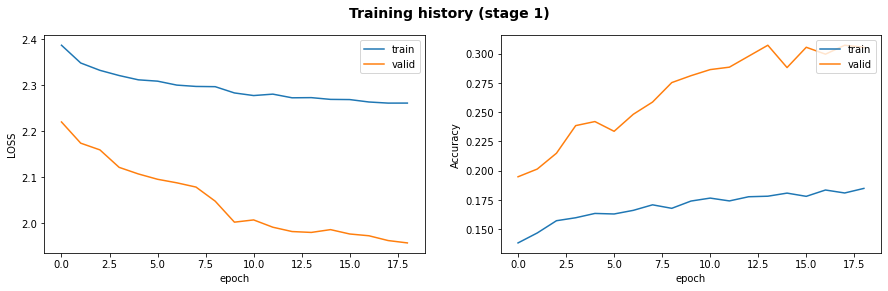

In [17]:
import pickle
from matplotlib import pyplot as plt

train_hist = pickle.load(open("./train_history_s1_autoencoderX.pkl","rb"))

# we plot both, the LOSS and MAE
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('Training history (stage 1)', fontsize=14, fontweight='bold')

ax1.plot(train_hist['loss'])
ax1.plot(train_hist['val_loss'])
ax1.set(xlabel='epoch', ylabel='LOSS')
ax1.legend(['train', 'valid'], loc='upper right')

ax2.plot(train_hist['accuracy'])
ax2.plot(train_hist['val_accuracy'])
ax2.set(xlabel='epoch', ylabel='Accuracy')
ax2.legend(['train', 'valid'], loc='upper right')  

### Stage 2

In [18]:
saved_model = load_model('stage1_autoencoderX.h5')

In [19]:
# set only 10 blocks to trainable
counter = 0
for layer in saved_model.layers:
    layer.trainable = True

In [20]:
initial_lr = 1e-4
#compile model using accuracy to measure model performance
saved_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=initial_lr), metrics=['accuracy'])

In [21]:
mc = ModelCheckpoint("stage2_autoencoderX.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
es = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=1, mode='auto')
lr_s = LearningRateScheduler(StepDecay(initAlpha=initial_lr), verbose=1)

In [22]:
X_train, X_val, y_train, y_val = load_and_split_data()

X_train shape:  (8715, 224, 224, 3)
y_train shape:  (8715, 11)
X_val shape:  (2905, 224, 224, 3)
y_val shape:  (2905, 11)


In [23]:
# training the model
history = saved_model.fit(
    X_train, 
    y_train, 
    epochs=epochs,
    batch_size=batch_size,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    validation_data=(X_val, y_val),
    callbacks=[mc, es, lr_s])

# saving training history (for future visualization)
with open('./train_history_s2_autoencoderX.pkl', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.


2022-03-16 11:59:00.617319: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


272/272 [==============================] - ETA: 0s - loss: 2.3301 - accuracy: 0.1561

2022-03-16 12:00:08.537259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


272/272 [==============================] - 75s 272ms/step - loss: 2.3301 - accuracy: 0.1561 - val_loss: 2.1306 - val_accuracy: 0.2295

Epoch 00001: val_accuracy improved from -inf to 0.22951, saving model to stage2_autoencoderX.h5
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.001.
272/272 [==============================] - 69s 252ms/step - loss: 2.3160 - accuracy: 0.1633 - val_loss: 2.0215 - val_accuracy: 0.2792

Epoch 00002: val_accuracy improved from 0.22951 to 0.27917, saving model to stage2_autoencoderX.h5
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 0.001.
272/272 [==============================] - 69s 252ms/step - loss: 2.3076 - accuracy: 0.1633 - val_loss: 2.0398 - val_accuracy: 0.2753

Epoch 00003: val_accuracy did not improve from 0.27917
Epoch 4/50

Epoch 00004: LearningRateScheduler setting learning rate to 0.001.
272/272 [==============================] - 68s 250ms/step - loss: 2.2991 - accuracy: 0.1687 - val_loss: 2.00

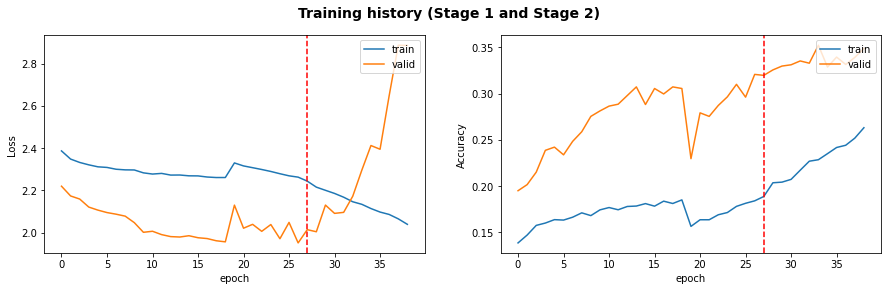

In [24]:
#@title Plot training history
train_hist = pickle.load(open("./train_history_s1_autoencoderX.pkl","rb"))
train_hist_2nd = pickle.load(open("./train_history_s2_autoencoderX.pkl","rb"))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('Training history (Stage 1 and Stage 2)', fontsize=14, fontweight='bold')

ax1.plot(train_hist['loss']+train_hist_2nd['loss'])
ax1.plot(train_hist['val_loss']+train_hist_2nd['val_loss'])
ax1.axvline(27, 0, 1, ls='--', color='r')
ax1.set(xlabel='epoch', ylabel='Loss')
ax1.legend(['train', 'valid'], loc='upper right')

ax2.plot(train_hist['accuracy']+train_hist_2nd['accuracy'])
ax2.plot(train_hist['val_accuracy']+train_hist_2nd['val_accuracy'])
ax2.axvline(27, 0, 1, ls='--', color='r')
ax2.set(xlabel='epoch', ylabel='Accuracy')
ax2.legend(['train', 'valid'], loc='upper right')

### Stage 3

In [ ]:
saved_model2 = load_model('stage2_v3.h5')

In [ ]:
#@title Set to trainable last 10 blocks
# setting all layers of the model to trainable
saved_model2.trainable = True

In [ ]:
initial_lr = 1e-5
#compile model using accuracy to measure model performance
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=initial_lr), metrics=['accuracy'])

In [ ]:
mc = ModelCheckpoint("stage3_v3.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
es = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=1, mode='auto')
lr_s = LearningRateScheduler(StepDecay(initAlpha=initial_lr), verbose=1)

In [ ]:
X_train, X_val, y_train, y_val = load_and_split_data()

In [ ]:
# training the model
history = saved_model.fit(
    X_train, 
    y_train, 
    epochs=epochs,
    batch_size=batch_size,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    validation_data=(X_val, y_val),
    callbacks=[mc, es, lr_s])

# saving training history (for future visualization)
with open('./train_history_s3_v3.pkl', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
#@title Plot training history
train_hist = pickle.load(open("./train_history_s1_v3.pkl","rb"))
train_hist_2nd = pickle.load(open("./train_history_s2_v3.pkl","rb"))
train_hist_3rd = pickle.load(open("./train_history_s3_v3.pkl","rb"))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('Training history (Stage 1, Stage 2, Stage 3)', fontsize=14, fontweight='bold')

ax1.plot(train_hist['loss']+train_hist_2nd['loss']+train_hist_3rd['loss'])
ax1.plot(train_hist['val_loss']+train_hist_2nd['val_loss']+train_hist_3rd['val_loss'])
ax1.axvline(36, 0, 1, ls='--', color='r')
ax1.axvline(70, 0, 1, ls='--', color='r')
ax1.set(xlabel='epoch', ylabel='Loss')
ax1.legend(['train', 'valid'], loc='upper right')

ax2.plot(train_hist['accuracy']+train_hist_2nd['accuracy']+train_hist_3rd['accuracy'])
ax2.plot(train_hist['val_accuracy']+train_hist_2nd['val_accuracy']+train_hist_3rd['val_accuracy'])
ax2.axvline(36, 0, 1, ls='--', color='r')
ax2.axvline(70, 0, 1, ls='--', color='r')
ax2.set(xlabel='epoch', ylabel='Accuracy')
ax2.legend(['train', 'valid'], loc='upper right')